In [1]:
%%time
# -*- coding: utf-8 -*-
from __future__ import print_function

import random
import multiprocessing
import os

import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch import nn, optim, cuda
from torchvision import datasets, transforms
from torchvision.transforms import transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torch.autograd import Variable


CPU times: user 671 ms, sys: 163 ms, total: 834 ms
Wall time: 2.55 s


In [2]:
# Environmental Settings

def seed_everything(seed): # Reproducibility를 위한 seed 고정 작업
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

seed_everything(42)

use_cuda = torch.cuda.is_available() # if the system supports CUDA -> True
device = torch.device("cuda" if use_cuda else "cpu")
print("Device: ", device, "\n");

# Training settings
batch_size = 256 

Device:  cuda 



In [3]:
# Dataset & Augmentation

train_data = datasets.CIFAR10(
    root="./data", # Download=True일 시, 데이터를 다운받을 경로 // Download=False일 시, 데이터가 존재하는 경로
    train=True,  # True -> Training set에서 data를 가져옴, False -> Test set에서 data를 가져옴
    download=True, # Data가 시스템 내부에 존재하는 지 여부
    transform=transforms.ToTensor(), # 위에서 정의한 data transformation을 적용
)

test_data = datasets.CIFAR10(
    root="./data",
    train=False, 
    download=True,
    transform=transforms.ToTensor(),
)

print("Train data shape:", train_data.data.shape)
print("Test data shape:", test_data.data.shape)

train_mean = train_data.data.mean(axis=(0, 1, 2))
train_std = train_data.data.std(axis=(0, 1, 2))

train_mean = train_mean / 255
train_std = train_std / 255

print("train_mean:", train_mean)
print("train_std:", train_std)


test_mean = test_data.data.mean(axis=(0, 1, 2))
test_std = test_data.data.std(axis=(0, 1, 2))

test_mean = test_mean / 255
test_std = test_std / 255

print("test_mean:", test_mean)
print("test_std:", test_std)


train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(test_mean, test_std)
])

train_data, test_data = '', ''

train_data = datasets.CIFAR10(
    root="./data", # Download=True일 시, 데이터를 다운받을 경로 // Download=False일 시, 데이터가 존재하는 경로
    train=True,  # True -> Training set에서 data를 가져옴, False -> Test set에서 data를 가져옴
    download=False, # Data가 시스템 내부에 존재하는 지 여부
    transform=train_transform, # 위에서 정의한 data transformation을 적용
)

test_data = datasets.CIFAR10(
    root="./data",
    train=False, 
    download=False,
    transform=test_transform,
)


train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size=batch_size,
                                          shuffle=False)

Failed download. Trying https -> http instead. Downloading http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Train data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)
train_mean: [0.49139968 0.48215841 0.44653091]
train_std: [0.24703223 0.24348513 0.26158784]
test_mean: [0.49421428 0.48513139 0.45040909]
test_std: [0.24665252 0.24289226 0.26159238]


In [4]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        # identity mapping, input과 output의 feature map size, filter 수가 동일한 경우 사용.
        self.shortcut = nn.Sequential()

        self.relu = nn.ReLU()

        # projection mapping using 1x1conv
        if stride != 1:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x


In [5]:
class ResNet(nn.Module):
    def __init__(self, block, num_block, num_classes=10, init_weights=True):
        super().__init__()

        self.in_channels=64
        # input size : (b x 3 x 227 x 227)
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False), # (b x 64 x 112 x 112)
            nn.BatchNorm2d(num_features=64), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1) # (b x 64 x 56 x 56)
        )

        self.conv2_x = self._make_layer(block, 64, num_block[0], 1) # (b x 64 x 56 x 56)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2) # (b x 128 x 28 x 28)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2) # (b x 256 x 14 x 14)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2) # (b x 512 x 7 x 7)

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1)) # (b x 512 x 1 x 1) 
        self.fc = nn.Linear(512, num_classes) # ( input -> output : 512 -> class 개수)

        # weights inittialization
        if init_weights:
            self._initialize_weights()

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels

        return nn.Sequential(*layers)

    def forward(self,x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        x = self.conv3_x(output)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    # define weight initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def resnet18():
    return ResNet(BasicBlock, [2,2,2,2])

In [6]:
model = resnet18()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5) 

print(model)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2_x): Sequential(
    (0): BasicBlock(
      (residual_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
      (relu): ReLU()
    )
    (1): BasicBlock(
      (residual_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


In [7]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # data, target = Variable(data), Variable(target)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [8]:
def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # data, target = Variable(data, volatile=True), Variable(target)
        data, target = data.to(device), target.to(device)
        output = model(data)
        # sum up batch loss
        test_loss += F.nll_loss(output, target, size_average=False).data
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('Test set({}): Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        epoch, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

Train Epoch: 1 [0/50000 (0%)]	Loss: 1.264762
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.188666
Test set(1): Average loss: -3.0709, Accuracy: 5564/10000 (56%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.056053
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.187222
Test set(2): Average loss: -3.4031, Accuracy: 6009/10000 (60%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.147857
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.972480
Test set(3): Average loss: -3.4824, Accuracy: 6074/10000 (61%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 0.923635
Train Epoch: 4 [25600/50000 (51%)]	Loss: 0.958971
Test set(4): Average loss: -3.7586, Accuracy: 6192/10000 (62%)

Train Epoch: 5 [0/50000 (0%)]	Loss: 1.021635
Train Epoch: 5 [25600/50000 (51%)]	Loss: 0.976363
Test set(5): Average loss: -3.9369, Accuracy: 6313/10000 (63%)

Train Epoch: 6 [0/50000 (0%)]	Loss: 0.969649
Train Epoch: 6 [25600/50000 (51%)]	Loss: 0.967704
Test set(6): Average loss: -4.1675, Accuracy: 6318/10000 (63%)

Train Epoch: 7 [0/50000 (0%)]	Loss: 0.906678
T

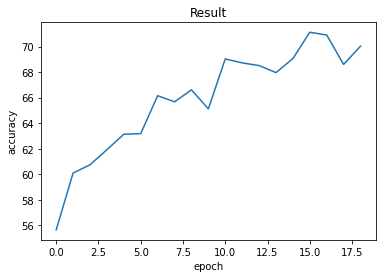

In [10]:
accuracy=[]
for epoch in range(1, 20):
    train(epoch)
    accuracy.append(test(epoch))

%matplotlib inline
from matplotlib import pyplot as plt
plt.plot([i for i in range(len(accuracy))], accuracy)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Result')
plt.show()